In [1]:
%load_ext autoreload
%autoreload 2
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2

sys.path.append("..")
from cv.locator import DroneLocator, ButtonFinder
from cv.dewarp import dewarp
import os

recal_paths="../../../../Downloads/recalibrating"
recal_imgs=(
    [
        os.path.join(recal_paths, name) 
        for name in os.listdir(recal_paths)
    ]

)

imgs_path = "../imgs/m4/"
landing_preds_path = os.path.join(imgs_path, "landing_det")
landing_pad_imgs = (
    [
        os.path.join(landing_preds_path, name) 
        for name in os.listdir(landing_preds_path)
    ]
)

gantry_preds_path = os.path.join(imgs_path, "end_offsets")
gantry_imgs = (
    [
        os.path.join(gantry_preds_path, name) 
        for name in os.listdir(gantry_preds_path)
    ]
)

# Adjusting Hyperparameters for button color filter in HSV space

In [2]:
from PIL import Image
locator = DroneLocator(
    linreg_path= "../cv/offset_model.pkl",
    show_circles=True,
    rough_radius_range= (20, 60),
    fine_radius_range= (30, 60),
    qr2but_range=(250, 300), 
    button_color_hsv_low = (25, 50, 100),
    button_color_hsv_high = (40, 255, 255),
)

# for i in gantry_imgs:
#     print(os.path.basename(i))
#     img = locator.imread(i)
#     plt.figure(figsize=(10,10))
#     plt.imshow(locator.color_filt(img), cmap="gray")
#     plt.show()

# Testing performance of locator 

-30 0 0


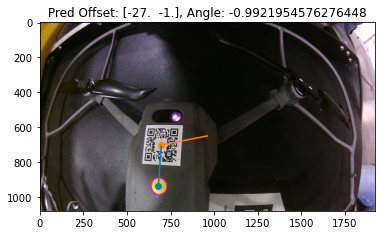

0 10 0


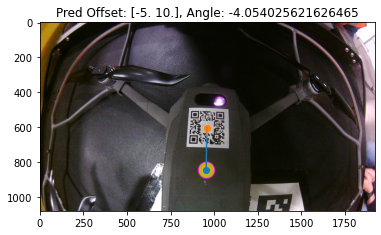

30 0 0


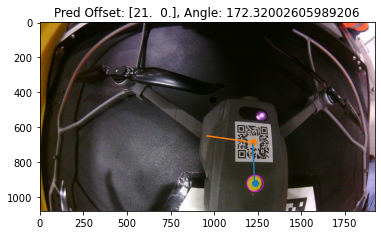

0 0 -10


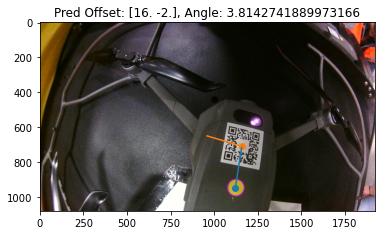

0 30 0
10 20 30
0 0 30
-30 20 -10


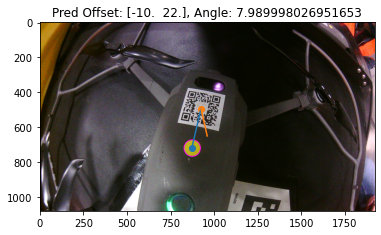

10 0 0


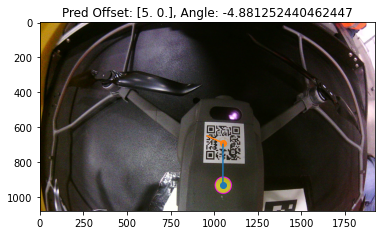

-10 0 0


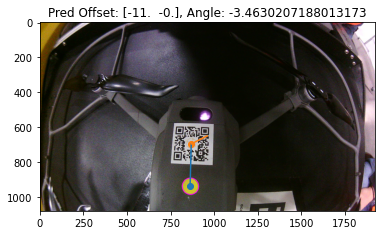

10 10 0


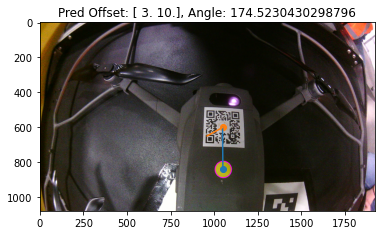

-30 -30 0


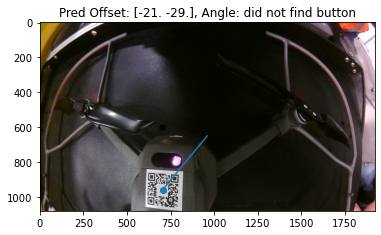

0 -10 0


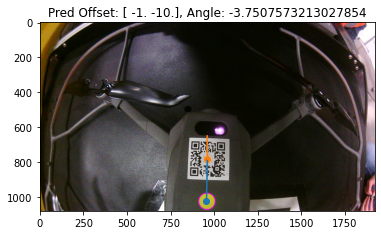

0 0 -30
0 0 10


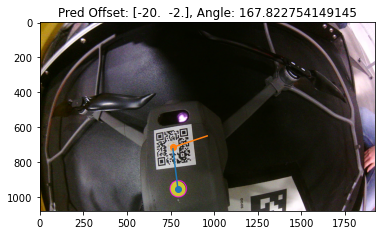

0 -30 0


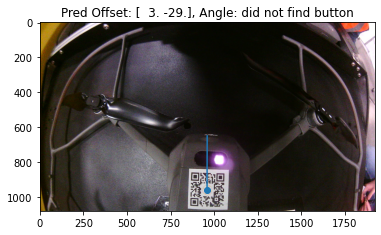

0 0 0


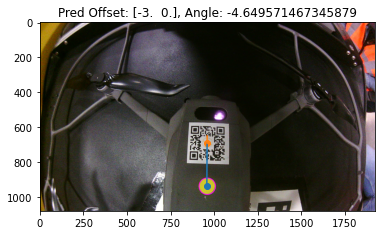

0.7647058823529411


In [6]:
from sklearn.linear_model import LinearRegression

locator = DroneLocator(
    linreg_path= "../cv/offset_model.pkl",
    canny_thresholds=(100, 10),
    show_circles=False,
    rough_radius_range= (30, 50),
    fine_radius_range= (30, 60),
    qr2but_range=(150, 600), 
    button_color_hsv_low = (25, 50, 100),
    button_color_hsv_high = (40, 255, 255),
)

x, y = [],[] 
corrects = 0

train = False

for i in recal_imgs:
    dx, dy, theta = os.path.basename(i).split(".jpg")[0].split("_")
    dx, dy, theta = int(dx), int(dy), int(theta)
    print(dx, dy, theta)
    img = locator.imread(i)
#     results = locator(undistort(img), True)
    results = locator(img, with_vis=True, train_offset=train)
    if results[0]:
        x.append((results[1], results[2]))
        y.append((dx, dy))
        corrects += 1
    
print(corrects / len(recal_imgs))
        

In [7]:
from sklearn.linear_model import LinearRegression
import pickle

if train:
    linreg = LinearRegression().fit(x, y)
    print(linreg.score(x,y))
    pickle.dump(linreg, open("../cv/offset_model.pkl", "wb"))

In [20]:
with_drone=set([
    3, 5, 7, 8, 12, 13, 18, 19, 20, 21, 22, 23, 25, 27, 28, 33, 35, 36, 37, 41, 42, 44, 45, 46, 50, 51,52, 53, 
])
len(with_drone)

28

(1080, 1920, 3)


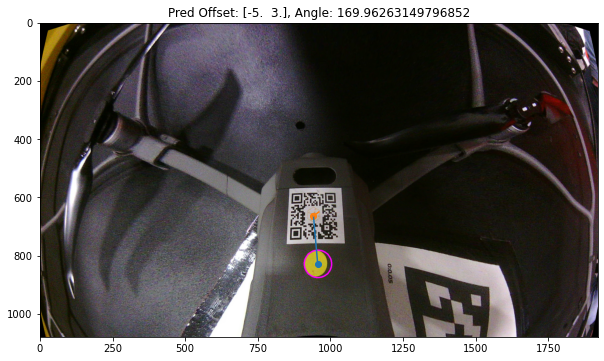

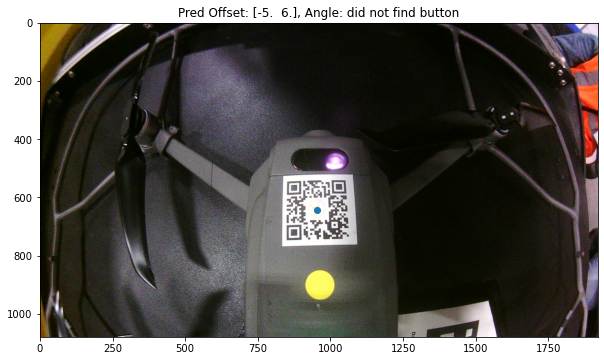

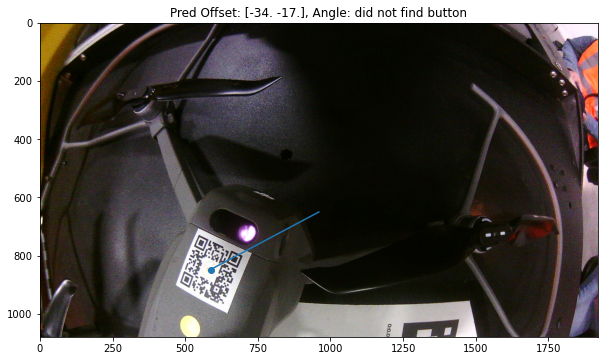

(False, 0, 0, 0)

<Figure size 720x720 with 0 Axes>

In [80]:
img = locator.imread("../../../../Downloads/2020-12-08_170615.jpg")
i1 = "../../../../Downloads/2020-12-08_170615.jpg"
i2 = "../../../../Downloads/2020-12-08_183824.jpg"
i3 = "../../../../Downloads/2020-12-08_185607.jpg"
i4 = "../../../../Downloads/2020-12-08_185615.jpg"
img = locator.imread(i1)
locator.show_circles = True
plt.figure(figsize=(10,10))
locator(undistort(img), True)
img = locator.imread(i2)
locator.show_circles = True
plt.figure(figsize=(10,10))
locator(img, True)
img = locator.imread(i3)
locator.show_circles = True
plt.figure(figsize=(10,10))
locator(img, True)
img = locator.imread(i4)
locator.show_circles = True
plt.figure(figsize=(10,10))
locator(img, True)
# butFinder.find(img)

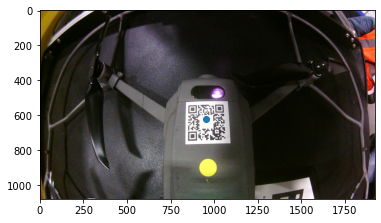

In [6]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../../../../Downloads/2020-12-08_183824.jpg"))
plt.scatter(x=954, y=620)

In [79]:
def undistort(img_path, balance=0.0, dim2=None, dim3=None):
    print(img_path.shape)
#     img_path.shape[:]
    DIM =(1920, 1080)

    K=np.array([[619.502080483064, 0.0, 954.9484455150281], [0.0, 613.596292291273, 558.8143723099438], [0.0, 0.0, 1.0]])
    D=np.array([[-0.14698664568761413], [1.2851197964314949], [-2.382630952864811], [1.2684594012272925]])
#     img = cv2.imread(img_path)
    img = img_path
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension.
    scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return undistorted_img